In [141]:
#! pip install Geopandas
#!pip install --use-deprecated=legacy-resolver pycaret[full]
#!pip install pycaret[full]

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
from pathlib import Path
import os.path


import seaborn as sns
from scipy import stats


# Data visualization
import matplotlib as mpl
import matplotlib.pyplot as plt

from matplotlib.pyplot import *
import imageio
from skimage.io import imread

from tqdm import tqdm

import cv2   #For image processing

import tensorflow as tf
#All tensorflow utilities for creating, training and working with a CNN
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model


import sklearn
from sklearn.preprocessing import LabelEncoder    #For encoding categorical variables
from sklearn.model_selection import train_test_split #For splitting of data
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline

from skimage.io import imread, imshow
from skimage.color import rgb2gray, rgb2hsv, rgba2rgb
from skimage.morphology import area_opening
from skimage.exposure import histogram
from skimage.filters import threshold_otsu
from skimage import io, color

from pycaret.datasets import get_data
from pycaret.regression import *

In [2]:
#set director for images
#All
image_train = Path('C:/Users/vasan/OneDrive/EmissionsDatathon/Dataset/Data/Train2a')

#Permian
image_train1= Path('C:/Users/vasan/OneDrive/EmissionsDatathon/Dataset/Data/Traina')

In [3]:
#set directory for csv files
dir_name = r'C:\Users\vasan\OneDrive\EmissionsDatathon\Zeroing Methane Emissions - Dataset'
filename_suffix = 'csv'

In [4]:
skiprows = 0
#Means read in the ',' as thousand seperator. Also drops all columns which are unnamed.
dfplume = pd.read_csv("plume_attribution_2019-2022 Jeremy Zhao.csv", thousands=',', skiprows = skiprows)
dfplume.head()

,Unnamed: 0,source_id,candidate_id,plume_lat,plume_lon,date,source_type,ipcc,qplume,sigma_qplume,time_of_detection,plume_tif,rgb_tif
0,0,A0001,GAO20210712t153850p0000-A,40.586588,-104.82330,2021-07-12 00:00:00,landfill,6A Solid Waste Disposal On Land,198.690714,56.089373,NaN,NaN,NaN
1,1,A0002,GAO20210720t152559p0000-A,40.574605,-104.68813,2021-07-20 00:00:00,livestock,3A2 Manure Management,659.384534,215.976289,NaN,NaN,NaN
2,2,A0002,GAO20210712t153850p0000-B,40.574387,-104.68855,2021-07-12 00:00:00,livestock,3A2 Manure Management,458.494606,167.196121,NaN,NaN,NaN
3,3,A0002,GAO20210718t152410p0000-B,40.573827,-104.68812,2021-07-18 00:00:00,livestock,3A2 Manure Management,242.145473,140.004235,NaN,NaN,NaN
4,4,A0003,GAO20210712t153850p0000-C,40.572121,-104.68871,2021-07-12 00:00:00,livestock,3A2 Manure Management,425.330806,171.220361,NaN,NaN,NaN


In [5]:
dfplume.shape

(8752, 13)

In [6]:
# Filter plume data for data after June 2020
dfplumef = dfplume[dfplume['date'] >= '2020-06-01']

In [7]:
dfplumef.shape

(5685, 13)

In [8]:
dfsource = pd.read_csv("source_list_2019-2022 Jeremy Zhao.csv", thousands=',', skiprows = skiprows)
dfsource.head()

,Unnamed: 0,source_id,source_lat,source_lon,number_overflights,source_persistence,qsource,sigma_qsource,source_type,confidence_in_persistence
0,0,G0001,35.249160,-119.57875,7,0.142857,96.853478,33.082042,tank,high
1,1,G0002,35.082251,-119.30443,7,0.142857,5.364176,1.441589,compressor,low
2,2,G0003,35.367999,-119.68495,7,0.857143,187.200884,79.748988,pipeline,high
3,3,G0004,35.343365,-119.64244,7,0.285714,44.889285,24.739863,pipeline,high
4,4,G0005,35.359342,-119.66100,7,1.000000,880.375832,244.909184,pipeline,high


In [9]:
dfsource.shape

(4199, 10)

In [10]:
filepaths = pd.Series(list(image_train.glob(r'**/*.tif')), name='Filepath').astype(str)

In [11]:
df_filepaths = filepaths.to_frame()

In [12]:
df_filepaths.to_excel("df_filepaths.xlsx")  

In [13]:
res = os.listdir(image_train)
df_filepaths['Name'] = pd.DataFrame (res, columns = ['FileName'])

In [14]:
df_filepaths['candidate_id'] = [x.split('_')[-0] for x in df_filepaths['Name']]

In [15]:
df_filepaths = df_filepaths.drop(df_filepaths[df_filepaths['Name'].str.contains('rgb')].index)

In [16]:
df_filepaths.shape

(2526, 3)

In [17]:
df_filepaths.nunique()

Filepath        2526
Name            2526
candidate_id    2526
dtype: int64

In [18]:
dup = dfplumef[dfplumef['candidate_id'].duplicated() == True]

In [19]:
dup.shape

(1460, 13)

In [20]:
#drop duplicates
dfplumef = dfplumef.drop_duplicates(subset='candidate_id', keep="first")

In [21]:
dfplumef.nunique()

Unnamed: 0           4225
source_id            2463
candidate_id         4225
plume_lat            4177
plume_lon            4037
date                  184
source_type            16
ipcc                    9
qplume               4221
sigma_qplume         4221
time_of_detection     221
plume_tif              61
rgb_tif                61
dtype: int64

In [22]:
dfdata = pd.merge(df_filepaths,dfplumef, on='candidate_id')

In [23]:
dfdata.shape

(2525, 15)

In [24]:
dfdata.head()

,Filepath,Name,candidate_id,Unnamed: 0,source_id,plume_lat,plume_lon,date,source_type,ipcc,qplume,sigma_qplume,time_of_detection,plume_tif,rgb_tif
0,C:\Users\vasan\OneDrive\EmissionsDatathon\Data...,ang20200708t192518-3_r1823_c108_ctr.tif,ang20200708t192518-3,2686,H0195,34.319899,-118.51149,2020-07-08 00:00:00,landfill,6A Solid Waste Disposal On Land,339.311781,204.404889,NaN,NaN,NaN
1,C:\Users\vasan\OneDrive\EmissionsDatathon\Data...,ang20200708t200101-1_r4784_c237_ctr.tif,ang20200708t200101-1,2433,H0094,35.059811,-119.38014,2020-07-08 00:00:00,pipeline,1B2 Oil & Natural Gas,143.699417,45.193937,NaN,NaN,NaN
2,C:\Users\vasan\OneDrive\EmissionsDatathon\Data...,ang20200708t200101-A_r502_c-24_ctr.tif,ang20200708t200101-A,2453,H0102,35.133777,-119.49487,2020-07-08 00:00:00,well,1B2 Oil & Natural Gas,114.342534,59.144830,NaN,NaN,NaN
3,C:\Users\vasan\OneDrive\EmissionsDatathon\Data...,ang20200708t200101-B_r3756_c132_ctr.tif,ang20200708t200101-B,2432,H0093,35.076695,-119.40862,2020-07-08 00:00:00,pipeline,1B2 Oil & Natural Gas,89.897169,11.419762,NaN,NaN,NaN
4,C:\Users\vasan\OneDrive\EmissionsDatathon\Data...,ang20200708t200905-1_r1236_c363_ctr.tif,ang20200708t200905-1,2231,H0017,35.200380,-119.49091,2020-07-08 00:00:00,pipeline,1B2 Oil & Natural Gas,657.233605,167.638633,NaN,NaN,NaN


In [25]:
dfdata=dfdata.dropna(subset=["qplume"])

In [26]:
dfsource.nunique()

Unnamed: 0                   4199
source_id                    4199
source_lat                   4196
source_lon                   4167
number_overflights             14
source_persistence             53
qsource                      4198
sigma_qsource                4198
source_type                    17
confidence_in_persistence      10
dtype: int64

In [27]:
dfdata2 = pd.merge(dfsource,dfdata, on='source_id')

In [28]:
dfdata2.to_excel("dfdata2.xlsx")  

In [29]:
dfdata2.nunique()

Unnamed: 0_x                 1472
source_id                    1472
source_lat                   1471
source_lon                   1467
number_overflights             12
source_persistence             30
qsource                      1472
sigma_qsource                1472
source_type_x                  15
confidence_in_persistence       3
Filepath                     2525
Name                         2525
candidate_id                 2525
Unnamed: 0_y                 2525
plume_lat                    2500
plume_lon                    2421
date                           83
source_type_y                  15
ipcc                            7
qplume                       2524
sigma_qplume                 2524
time_of_detection               0
plume_tif                       0
rgb_tif                         0
dtype: int64

In [30]:
dfdata2 = dfdata2.drop(columns=['plume_tif', 'rgb_tif'])

In [31]:
skiprows = 0
#Means read in the ',' as thousand seperator. Also drops all columns which are unnamed.
dfplumeper = pd.read_csv("permian_plume_list_2019 Jeremy Zhao.csv", thousands=',', skiprows = skiprows)
dfplumeper.head()

,Unnamed: 0,source_id,plume_lat,plume_lon,candidate_id,date,time,qplume,sigma_qplume,active_flair_detected,inactive_flair_detected
0,0,P00001,32.212063,-103.697076,ang20190922t192642-2,2019-09-22,19:26:42,2579.528100,902.732655,False,False
1,1,P00002,32.200072,-103.673301,ang20190922t192642-4,2019-09-22,19:26:42,420.725207,147.155782,False,False
2,2,P00003,32.116008,-103.626345,ang20190922t192642-5,2019-09-22,19:26:42,1051.909600,339.267587,False,False
3,3,P00004,32.322594,-103.816072,ang20190922t194340-1,2019-09-22,19:43:40,1736.644250,1035.427670,False,False
4,4,P00005,32.284083,-103.793989,ang20190922t194340-2,2019-09-22,19:43:40,870.605019,435.968147,False,False


In [32]:
dfplumeper.shape

(3067, 11)

In [33]:
dfsourceper = pd.read_csv("permian_source_list_2019 Jeremy Zhao.csv", thousands=',', skiprows = skiprows)
dfsourceper.head()

,Unnamed: 0,source_id,source_lat,source_lon,type,ipcc_sector,number_overflights,source_persistence,confidence_in_persistence,qsource,sigma_qsource
0,0,P00001,32.212086,-103.697212,tank,1B2 Oil & Natural Gas,12,0.833333,0.968324,865.484230,307.380288
1,1,P00002,32.199937,-103.673324,tank,1B2 Oil & Natural Gas,12,0.333333,0.968324,207.089504,47.441634
2,2,P00003,32.116135,-103.626582,tank,1B2 Oil & Natural Gas,12,0.583333,0.968324,305.700650,97.254972
3,3,P00004,32.322594,-103.816072,pipeline,1B2 Oil & Natural Gas,11,0.090909,0.957765,157.876750,94.129788
4,4,P00005,32.284279,-103.793918,tank,1B2 Oil & Natural Gas,10,0.200000,0.943686,161.404695,51.069466


In [34]:
dfsourceper.shape

(1756, 11)

In [35]:
filepaths1 = pd.Series(list(image_train1.glob(r'**/*.tif')), name='Filepath').astype(str)

In [36]:
df_filepaths1 = filepaths1.to_frame()

In [37]:
res = os.listdir(image_train1)
df_filepaths1['Name'] = pd.DataFrame (res, columns = ['FileName'])

In [38]:
df_filepaths1['candidate_id'] = [x.split('_')[-0] for x in df_filepaths1['Name']]

In [39]:
df_filepaths1.head()

,Filepath,Name,candidate_id
0,C:\Users\vasan\OneDrive\EmissionsDatathon\Data...,ang20190922t192642-2_r4578_c217_ctr.tif,ang20190922t192642-2
1,C:\Users\vasan\OneDrive\EmissionsDatathon\Data...,ang20190922t192642-2_r4578_c217_rgb.tif,ang20190922t192642-2
2,C:\Users\vasan\OneDrive\EmissionsDatathon\Data...,ang20190922t192642-4_r4928_c373_ctr.tif,ang20190922t192642-4
3,C:\Users\vasan\OneDrive\EmissionsDatathon\Data...,ang20190922t192642-4_r4928_c373_rgb.tif,ang20190922t192642-4
4,C:\Users\vasan\OneDrive\EmissionsDatathon\Data...,ang20190922t192642-5_r6423_c113_ctr.tif,ang20190922t192642-5


In [40]:
df_filepaths1.to_excel("df_filepaths1.xlsx")  

In [41]:
df_filepaths1 = df_filepaths1.drop(df_filepaths1[df_filepaths1['Name'].str.contains('rgb')].index)

In [42]:
df_filepaths1.shape

(3763, 3)

In [43]:
dup1 = dfplumeper[dfplumeper['candidate_id'].duplicated() == True]

In [44]:
dup1.shape

(0, 11)

In [45]:
dfdataper = pd.merge(df_filepaths1,dfplumeper, on='candidate_id')

In [46]:
dfdataper.head()

,Filepath,Name,candidate_id,Unnamed: 0,source_id,plume_lat,plume_lon,date,time,qplume,sigma_qplume,active_flair_detected,inactive_flair_detected
0,C:\Users\vasan\OneDrive\EmissionsDatathon\Data...,ang20190922t192642-2_r4578_c217_ctr.tif,ang20190922t192642-2,0,P00001,32.212063,-103.697076,2019-09-22,19:26:42,2579.528100,902.732655,False,False
1,C:\Users\vasan\OneDrive\EmissionsDatathon\Data...,ang20190922t192642-4_r4928_c373_ctr.tif,ang20190922t192642-4,1,P00002,32.200072,-103.673301,2019-09-22,19:26:42,420.725207,147.155782,False,False
2,C:\Users\vasan\OneDrive\EmissionsDatathon\Data...,ang20190922t192642-5_r6423_c113_ctr.tif,ang20190922t192642-5,2,P00003,32.116008,-103.626345,2019-09-22,19:26:42,1051.909600,339.267587,False,False
3,C:\Users\vasan\OneDrive\EmissionsDatathon\Data...,ang20190922t192642-A_r3270_c384_ctr.tif,ang20190922t192642-A,759,P00156,32.283447,-103.741815,2019-09-22,19:26:42,296.676732,98.755811,False,False
4,C:\Users\vasan\OneDrive\EmissionsDatathon\Data...,ang20190922t192642-B_r4034_c360_ctr.tif,ang20190922t192642-B,760,P00119,32.244361,-103.711379,2019-09-22,19:26:42,640.968143,190.138173,False,False


In [47]:
dfdataper.nunique()

Filepath                   3067
Name                       3067
candidate_id               3067
Unnamed: 0                 3067
source_id                  1756
plume_lat                  3061
plume_lon                  3058
date                         31
time                        552
qplume                     3066
sigma_qplume               3066
active_flair_detected         2
inactive_flair_detected       2
dtype: int64

In [48]:
dfdataper2 = pd.merge(dfsourceper,dfdataper, on='source_id')

In [49]:
dfdataper2.shape

(3067, 23)

In [50]:
dfdataper2.nunique()

Unnamed: 0_x                 1756
source_id                    1756
source_lat                   1756
source_lon                   1756
type                            5
ipcc_sector                     1
number_overflights             14
source_persistence             46
confidence_in_persistence      14
qsource                      1756
sigma_qsource                1756
Filepath                     3067
Name                         3067
candidate_id                 3067
Unnamed: 0_y                 3067
plume_lat                    3061
plume_lon                    3058
date                           31
time                          552
qplume                       3066
sigma_qplume                 3066
active_flair_detected           2
inactive_flair_detected         2
dtype: int64

In [51]:
dfdata2 = dfdata2.drop(columns=['Unnamed: 0_x', 'Unnamed: 0_y','time_of_detection'])

In [52]:
dfdata2 = dfdata2.drop(columns=['source_type_x'])

In [53]:
dfdataper2.nunique()

Unnamed: 0_x                 1756
source_id                    1756
source_lat                   1756
source_lon                   1756
type                            5
ipcc_sector                     1
number_overflights             14
source_persistence             46
confidence_in_persistence      14
qsource                      1756
sigma_qsource                1756
Filepath                     3067
Name                         3067
candidate_id                 3067
Unnamed: 0_y                 3067
plume_lat                    3061
plume_lon                    3058
date                           31
time                          552
qplume                       3066
sigma_qplume                 3066
active_flair_detected           2
inactive_flair_detected         2
dtype: int64

In [54]:
dfdataper2 = dfdataper2.drop(columns=['Unnamed: 0_x', 'Unnamed: 0_y','active_flair_detected','time'])

In [55]:
dfdataper2 = dfdataper2.drop(columns=['inactive_flair_detected'])

In [56]:
dfdataper2 = dfdataper2.rename(columns={'type': 'source_type_y', 'ipcc_sector': 'ipcc'})

In [57]:
dfdataper2.to_excel("dfdataper2.xlsx")  

In [58]:
data = pd.concat([dfdataper2, dfdata2])

In [59]:
data.shape

(5592, 18)

In [60]:
data.nunique()

source_id                    3228
source_lat                   3226
source_lon                   3219
source_type_y                  15
ipcc                            7
number_overflights             14
source_persistence             64
confidence_in_persistence      17
qsource                      3228
sigma_qsource                3228
Filepath                     5592
Name                         5592
candidate_id                 5592
plume_lat                    5559
plume_lon                    5464
date                          114
qplume                       5590
sigma_qplume                 5590
dtype: int64

In [61]:
data['Uncern'] = (data.sigma_qsource/data.qsource)*100

count    5592.000000
mean       35.181001
std        12.840589
min         1.936254
25%        26.258181
50%        33.693018
75%        41.999900
max       111.529334
Name: Uncern, dtype: float64


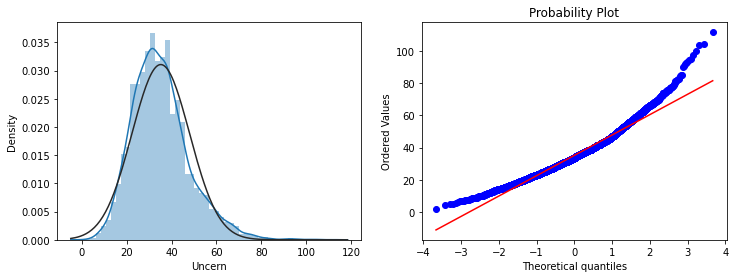

In [62]:
print(data.Uncern.describe())

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.distplot(data.Uncern.dropna() , fit=stats.norm);
plt.subplot(1,2,2)
_=stats.probplot(data.Uncern.dropna(), plot=plt)

In [63]:
(data['Uncern'] > 100).sum()

4

In [64]:
(data['Uncern'] > 30).sum()

3514

In [65]:
datamodel = data

In [66]:
datamodel.shape

(5592, 19)

In [69]:
def image_processing(fil):
#    Open image and import it as a numpy array
    image2 = imread(fil)
    
    feature_matrix = np.zeros((217,217))
    
    for i in range(0,image2.shape[0]):
        for j in range(0,image2.shape[1]):
            feature_matrix[i][j] = ((int(image2[i,j,0]) + int(image2[i,j,1]) + int(image2[i,j,2]))/3)
        
    features = np.reshape(feature_matrix, (217*217))
    
    return features

In [70]:
image_list = []

In [73]:
for file in tqdm(datamodel['Filepath'].tolist()[:]):
    image_list.append(image_processing(file))

100%|██████████| 5592/5592 [02:56<00:00, 31.66it/s]


In [74]:
X = np.array(image_list)

In [79]:
np.save('processed_217x217_image.npy',X,allow_pickle=True)

In [77]:
Y = np.array(datamodel.qplume.tolist())

In [78]:
# Split the data into train and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Split the train set into train and validation sets
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.25, random_state=42)

In [80]:
img_rows, img_cols = 217, 217
input_shape = (img_rows, img_cols, 1)

X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
X_val = X_val.reshape(X_val.shape[0], img_rows, img_cols, 1)

X_val.shape

(1119, 217, 217, 1)

In [81]:
X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
X_val = X_val.reshape(X_val.shape[0], img_rows, img_cols, 1)

In [82]:
#Define a Convolutional Neural Network Model

model = Sequential()

model.add(Conv2D(filters = 16, kernel_size = (3, 3), activation='relu',
                 input_shape = input_shape))
model.add(BatchNormalization())
model.add(Conv2D(filters = 16, kernel_size = (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(strides=(2,2)))
model.add(Dropout(0.25))
model.add(Conv2D(filters = 32, kernel_size = (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters = 32, kernel_size = (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(strides=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.25))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.4))
#model.add(Dense(n_classes, activation='softmax'))
model.add(Dense(1, activation='relu'))
learning_rate = 0.001

model.compile(loss = 'mse',
              optimizer = Adam(learning_rate))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 215, 215, 16)      160       
                                                                 
 batch_normalization (BatchN  (None, 215, 215, 16)     64        
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 213, 213, 16)      2320      
                                                                 
 batch_normalization_1 (Batc  (None, 213, 213, 16)     64        
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 106, 106, 16)     0         
 )                                                               
                                                        

In [83]:
save_at = "model_regression2.hdf5"
save_best2 = ModelCheckpoint (save_at, monitor='val_accuracy', verbose=0, save_best_only=True, save_weights_only=False, mode='max')

In [84]:
#Train the CNN

history = model.fit( X_train, Y_train, 
                    epochs = 15, batch_size = 100, 
                    callbacks=[save_best2], verbose=1, 
                   validation_data = (X_val, Y_val))

Epoch 1/15
34/34 [==============================] - 189s 5s/step - loss: 460328.2500 - val_loss: 324345.4375
Epoch 2/15
34/34 [==============================] - 275s 8s/step - loss: 341329.8750 - val_loss: 559044.6875
Epoch 3/15
34/34 [==============================] - 176s 5s/step - loss: 292485.9062 - val_loss: 545458.8750
Epoch 4/15
34/34 [==============================] - 192s 6s/step - loss: 255419.5000 - val_loss: 733500.0625
Epoch 5/15
34/34 [==============================] - 173s 5s/step - loss: 181778.2969 - val_loss: 1458723.7500
Epoch 6/15
34/34 [==============================] - 175s 5s/step - loss: 131625.2188 - val_loss: 5082626.0000
Epoch 7/15
34/34 [==============================] - 196s 6s/step - loss: 123447.5547 - val_loss: 7069542.5000
Epoch 8/15
34/34 [==============================] - 176s 5s/step - loss: 96845.0781 - val_loss: 19304604.0000
Epoch 9/15
34/34 [==============================] - 179s 5s/step - loss: 96956.4609 - val_loss: 2428371.2500
Epoch 10/15
34/

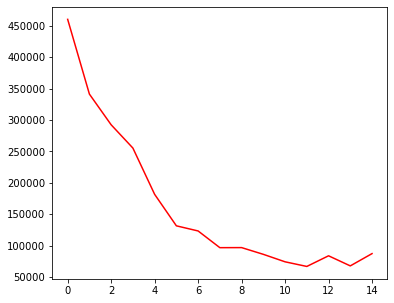

In [88]:
plt.figure(figsize=(6, 5))
plt.plot(history.history['loss'], color='r')
#plt.plot(history.history['val_loss'], color='g')
plt.show()

In [86]:
Y_pred = np.round(model.predict(X_test))

35/35 [==============================] - 8s 227ms/step


In [87]:
# Calculate the mean squared error
mse = mean_squared_error(Y_test, Y_pred)

# Calculate the root mean squared error
rmse = np.sqrt(mse)

print("Root Mean Squared Error:", rmse)

r2 = r2_score(Y_test, Y_pred)
print("Test R^2 Score: {:.5f}".format(r2))

Root Mean Squared Error: 1151.913368786946
Test R^2 Score: -0.81368


In [89]:
image_sub = []

In [90]:
image_test = Path('C:/Users/vasan/OneDrive/EmissionsDatathon/Dataset/Data/Test')

In [91]:
testpaths = pd.Series(list(image_test.glob(r'**/*.png')), name='Testpath').astype(str)

In [92]:
df_testpaths = testpaths.to_frame()

In [93]:
res = os.listdir(image_test)
df_testpaths['Name'] = pd.DataFrame (res, columns = ['TestName'])

In [94]:
for file in tqdm(df_testpaths['Testpath'].tolist()[:]):
    image_sub.append(image_processing(file))

100%|██████████| 20/20 [00:00<00:00, 52.72it/s]


In [95]:
X_sub = np.array(image_sub)

In [96]:
np.save('sub_image.npy',X_sub,allow_pickle=True)

In [97]:
X_sub = X_sub.reshape(X_sub.shape[0], img_rows, img_cols, 1)
X_sub = X_sub.reshape(X_sub.shape[0], img_rows, img_cols, 1)
X_sub

array([[[[ 49.66666667],
         [ 49.66666667],
         [ 49.        ],
         ...,
         [  0.        ],
         [  0.        ],
         [  0.        ]],

        [[ 51.66666667],
         [ 49.33333333],
         [ 46.33333333],
         ...,
         [  0.        ],
         [  0.        ],
         [  0.        ]],

        [[ 49.33333333],
         [ 49.66666667],
         [ 48.        ],
         ...,
         [  0.        ],
         [  0.        ],
         [  0.        ]],

        ...,

        [[  0.        ],
         [  0.        ],
         [  0.        ],
         ...,
         [  0.        ],
         [  0.        ],
         [  0.        ]],

        [[  0.        ],
         [  0.        ],
         [  0.        ],
         ...,
         [  0.        ],
         [  0.        ],
         [  0.        ]],

        [[  0.        ],
         [  0.        ],
         [  0.        ],
         ...,
         [  0.        ],
         [  0.        ],
         [  0.   

In [98]:
Y_sub = np.round(model.predict(X_sub))

1/1 [==============================] - 0s 166ms/step


In [99]:
Y_sub

array([[1589.],
       [1203.],
       [ 961.],
       [1216.],
       [1612.],
       [1211.],
       [ 999.],
       [1140.],
       [1171.],
       [1385.],
       [1756.],
       [2117.],
       [1495.],
       [1522.],
       [2757.],
       [2459.],
       [2096.],
       [2090.],
       [2625.],
       [2616.]], dtype=float32)